## 1. train textCNN model
## 2. extract the middle layer as document Vector
## 3. transform JD&CV to Vector
## 4. use FAISS to get most simmilar Vector from Vector Matrix

In [2]:
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Embedding, LSTM, MaxPooling1D,BatchNormalization,GRU, SpatialDropout1D
from keras.layers.core import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from keras import metrics, regularizers
from keras.preprocessing import sequence
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from bs4 import BeautifulSoup
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# import Job Description dataset

In [3]:
data = pd.read_csv(r'../Data/JD.csv',usecols = ['Query','Description'])
data.head(10)

,Query,Description
0,Administrative Assistant,This Administrative Assistant position is resp...
1,Administrative Assistant,ADMINISTRATIVE ASSISTANT Part Time The West Or...
2,Administrative Assistant,Administrative Assistant - In Bus 26yrs Fashi...
3,Sales Representative,Are you ready for something new? Are you tired...
4,Customer Service Representative,Superior Staff Resources is currently seeking ...
5,Customer Service Representative,<br />\r<span><strong>The Opportunity:</strong...
6,Java Developer,<P><STRONG>As a member of the Web and Portal D...
7,Java Developer,<BR>\r<TABLE border=0 cellSpacing=0 cellPaddin...
8,Administrative Assistant,The main function of this role is to provide a...
9,Financial Analyst,Financial Analyst\n Perform portfolio analysis...


# data clean

In [4]:
data = data.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):
#     text = BeautifulSoup(text, "lxml").text
#     pat = re.compile('<[^>]+>', re.S)
    text = text.replace(r'\\n', ' ').replace(r'\\r', ' ').replace(r'\r', ' ').replace(r'\n', ' ')
    
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    text = cleanr.sub(' ', text)
    
#     text = text.replace(r'\\n', ' ').replace(r'\\r', ' ').replace(r'\r', ' ').replace(r'\n', ' ')
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split()) # remove stopwors from text
    return text

In [5]:
data['Query'] = data['Query'].apply(clean_text)
data['Description'] = data['Description'].apply(clean_text)

# sample

In [6]:
import re
from bs4 import BeautifulSoup

def string_process(l):
#     temp_list = [str(i).replace('\\n', ' ').replace('\\r', ' ').replace('\r', ' ').replace('\n', ' ').strip().lower() for i in nlp(l)]
#     temp_string = ' '.join( temp_list )
#     temp_list = [str(i) for i in nlp(temp_string)] 
    temp_list = l.split()
    return temp_list

In [7]:
data['text_clean'] = data['Description'].apply( string_process )
data['len'] = data['text_clean'].apply(len)
data = data[data['len'] < 500]
data

,Query,Description,text_clean,len
0,administrative assistant,this administrative assistant position is resp...,"[this, administrative, assistant, position, is...",90
1,administrative assistant,administrative assistant part time the west or...,"[administrative, assistant, part, time, the, w...",70
2,administrative assistant,administrative assistant in bus 26yrs fashion ...,"[administrative, assistant, in, bus, 26yrs, fa...",308
3,sales representative,are you ready for something new are you tired ...,"[are, you, ready, for, something, new, are, yo...",83
4,customer service representative,superior staff resources is currently seeking ...,"[superior, staff, resources, is, currently, se...",254
...,...,...,...,...
72287,business analyst,ability construct complex sql statement analyz...,"[ability, construct, complex, sql, statement, ...",148
72288,business analyst,join u pursue disruptive new vision make machi...,"[join, u, pursue, disruptive, new, vision, mak...",265
72289,business analyst,duty high level independent decision making au...,"[duty, high, level, independent, decision, mak...",77
72290,business analyst,crowdstrike leading provider nextgeneration en...,"[crowdstrike, leading, provider, nextgeneratio...",315


In [8]:
import numpy as np
from gensim.models import KeyedVectors

In [9]:
# load the Stanford GloVe model
filename = r'../word2vec/glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [10]:
word2idx = {"PAD": 0,"UNK": 1} # 初始化 `[word : token]` 字典，后期 tokenize 语料库就是用该词典。
vocab_list = [(k, model.wv[k]) for k, v in model.wv.vocab.items()]

# 存储所有 word2vec 中所有向量的数组，留意其中多一位，词向量全为 0， 用于 padding
embeddings_matrix = np.zeros((len(model.wv.vocab.items()) + 2, model.vector_size))
for i in range(len(vocab_list)):
    word = vocab_list[i][0]
    word2idx[word] = i + 2
    embeddings_matrix[i + 2] = vocab_list[i][1]
    
embeddings_matrix[1] = np.mean(embeddings_matrix, axis=0)

/home/lothar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/home/lothar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [11]:
max_seq_length = 500

In [12]:
def PreProcessInputData( text ):
    word_labels = []

    for sequence in text:
        len_text = len(sequence)

        ###########################################
        temp_word_labels = []
        for w in sequence:
            temp_word_labels.append( word2idx.get( str(w).lower(),1 ) )

        ###########################################
        temp_word_labels = temp_word_labels + [0] * ( max_seq_length - len_text )
        word_labels.append( temp_word_labels )

    return word_labels

In [13]:
def get_argmax( l ):
    return np.argmax(l)

In [14]:
XX = np.array( PreProcessInputData( data['text_clean'] ) )
YY = pd.get_dummies(data['Query']).values

In [15]:
data['category'] = list( YY )
data['category'] = data['category'].apply( get_argmax )
data

,Query,Description,text_clean,len,category
0,administrative assistant,this administrative assistant position is resp...,"[this, administrative, assistant, position, is...",90,2
1,administrative assistant,administrative assistant part time the west or...,"[administrative, assistant, part, time, the, w...",70,2
2,administrative assistant,administrative assistant in bus 26yrs fashion ...,"[administrative, assistant, in, bus, 26yrs, fa...",308,2
3,sales representative,are you ready for something new are you tired ...,"[are, you, ready, for, something, new, are, yo...",83,24
4,customer service representative,superior staff resources is currently seeking ...,"[superior, staff, resources, is, currently, se...",254,6
...,...,...,...,...,...
72287,business analyst,ability construct complex sql statement analyz...,"[ability, construct, complex, sql, statement, ...",148,4
72288,business analyst,join u pursue disruptive new vision make machi...,"[join, u, pursue, disruptive, new, vision, mak...",265,4
72289,business analyst,duty high level independent decision making au...,"[duty, high, level, independent, decision, mak...",77,4
72290,business analyst,crowdstrike leading provider nextgeneration en...,"[crowdstrike, leading, provider, nextgeneratio...",315,4


In [16]:
temp_DF = data[['Query','category']].drop_duplicates()

category_dict = {}
for ind, row in temp_DF.iterrows():
    category_dict[ row['category'] ] = row['Query']

category_dict

{2: 'administrative assistant',
 24: 'sales representative',
 6: 'customer service representative',
 12: 'java developer',
 9: 'financial analyst',
 17: 'project manager',
 8: 'executive assistant',
 13: 'maintenance technician',
 16: 'physical therapist',
 28: 'store manager',
 27: 'staff accountant',
 10: 'inside sales representative',
 0: 'account executive',
 18: 'receptionist',
 26: 'senior accountant',
 4: 'business analyst',
 19: 'restaurant manager',
 1: 'account representative',
 20: 'retail sales associate',
 25: 'sales representative account manager customer service',
 23: 'sales management trainee',
 11: 'janiking franchise business opportunity',
 15: 'own your own franchise',
 5: 'cashier',
 22: 'sales franchise',
 7: 'customer service sales representative part time work',
 14: 'mobile tool sales franchise distributor',
 3: 'benefits consultant',
 21: 'sales customer service part or full time summer work'}

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split( XX,YY, test_size = 0.2, random_state = 42)
print( X_train.shape, Y_train.shape )
print( X_test.shape, Y_test.shape )

(54070, 500) (54070, 29)
(13518, 500) (13518, 29)


In [18]:
len( set( data['Query'] ) )

29

# textCNN  Embeding

In [19]:
from tensorflow import keras

feature_size = max_seq_length
dropout_rate = 0.2
num_classes  = len( set( data['Query'] ) )

inputs = keras.Input(shape=(500,), name='input_data')

embed = keras.layers.Embedding(
    len(embeddings_matrix), 
    100,
    weights=[embeddings_matrix],
    trainable=False,
#     mask_zero=True,
    input_length=XX.shape[1]
    )(inputs)
# single channel. If using real embedding, you can set one static
embed = keras.layers.Reshape((500, 100, 1), name='add_channel')(embed)

pool_outputs = []
for filter_size in [3,4,5]:
    filter_shape = (filter_size, 100)
    conv = keras.layers.Conv2D(150, filter_shape, strides=(1, 1), padding='valid',
                               data_format='channels_last', activation='relu',
                               kernel_initializer='glorot_normal',
                               bias_initializer=keras.initializers.constant(0.1),
                               name='convolution_{:d}'.format(filter_size))(embed)
    max_pool_shape = (feature_size - filter_size + 1, 1)
    pool = keras.layers.MaxPool2D(pool_size=max_pool_shape,
                                  strides=(1, 1), padding='valid',
                                  data_format='channels_last',
                                  name='max_pooling_{:d}'.format(filter_size))(conv)
    pool_outputs.append(pool)

pool_outputs = keras.layers.concatenate(pool_outputs, axis=-1, name='concatenate')
pool_outputs = keras.layers.Flatten(data_format='channels_last', name='flatten')(pool_outputs)
pool_outputs = keras.layers.Dropout(dropout_rate, name='dropout')(pool_outputs)

outputs = keras.layers.Dense(num_classes, activation='softmax',
                             kernel_initializer='glorot_normal',
                             bias_initializer=keras.initializers.constant(0.1),
                             name='dense')(pool_outputs)

model = keras.Model(inputs=inputs, outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 100)     40000200    input_data[0][0]                 
__________________________________________________________________________________________________
add_channel (Reshape)           (None, 500, 100, 1)  0           embedding[0][0]                  
_____________________________________________________________________________________________

In [21]:
epochs = 5
batch_size = 128

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2) #,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]

Train on 43256 samples, validate on 10814 samples
Epoch 1/5
43256/43256 [==============================] - 287s 7ms/sample - loss: 0.5487 - acc: 0.8601 - val_loss: 0.2038 - val_acc: 0.9399
Epoch 2/5
43256/43256 [==============================] - 285s 7ms/sample - loss: 0.1886 - acc: 0.9426 - val_loss: 0.1802 - val_acc: 0.9502
Epoch 3/5
43256/43256 [==============================] - 301s 7ms/sample - loss: 0.1430 - acc: 0.9547 - val_loss: 0.1596 - val_acc: 0.9489
Epoch 4/5
43256/43256 [==============================] - 289s 7ms/sample - loss: 0.1184 - acc: 0.9624 - val_loss: 0.1518 - val_acc: 0.9546
Epoch 5/5
43256/43256 [==============================] - 287s 7ms/sample - loss: 0.1007 - acc: 0.9678 - val_loss: 0.1497 - val_acc: 0.9521


In [22]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

13518/13518 [==============================] - 38s 3ms/sample - loss: 0.1440 - acc: 0.9525
Test set
  Loss: 0.144
  Accuracy: 0.953


In [23]:
XX.shape

(67588, 500)

# sample 500 data
# extract middle layer as document distribution presentation

In [44]:
import random
import tensorflow as tf

x_list = []
y_list = []

index = 0
while True:
    if index >= 3000:
        break
    
    try:
        ranIndex = random.randint( 0,len( XX ) )

        layer_output = model.get_layer('concatenate').output
        intermediate_model = tf.keras.models.Model(inputs=model.input,outputs=layer_output)
        intermediate_prediction = intermediate_model.predict( XX[ranIndex:ranIndex+1] )

        Y_index = YY[ranIndex:ranIndex+1]

#         print( intermediate_prediction[0][0][0] )
        x_list.append( intermediate_prediction[0][0][0] )
#         y_list.append( data['Query'][ranIndex] )
        y_list.append( YY[ranIndex] )
#         print()
        index += 1

    except:
        print( 'Error' )

In [45]:
c_list = [ np.argmax(y) for y in y_list ]

# t-sne visualization

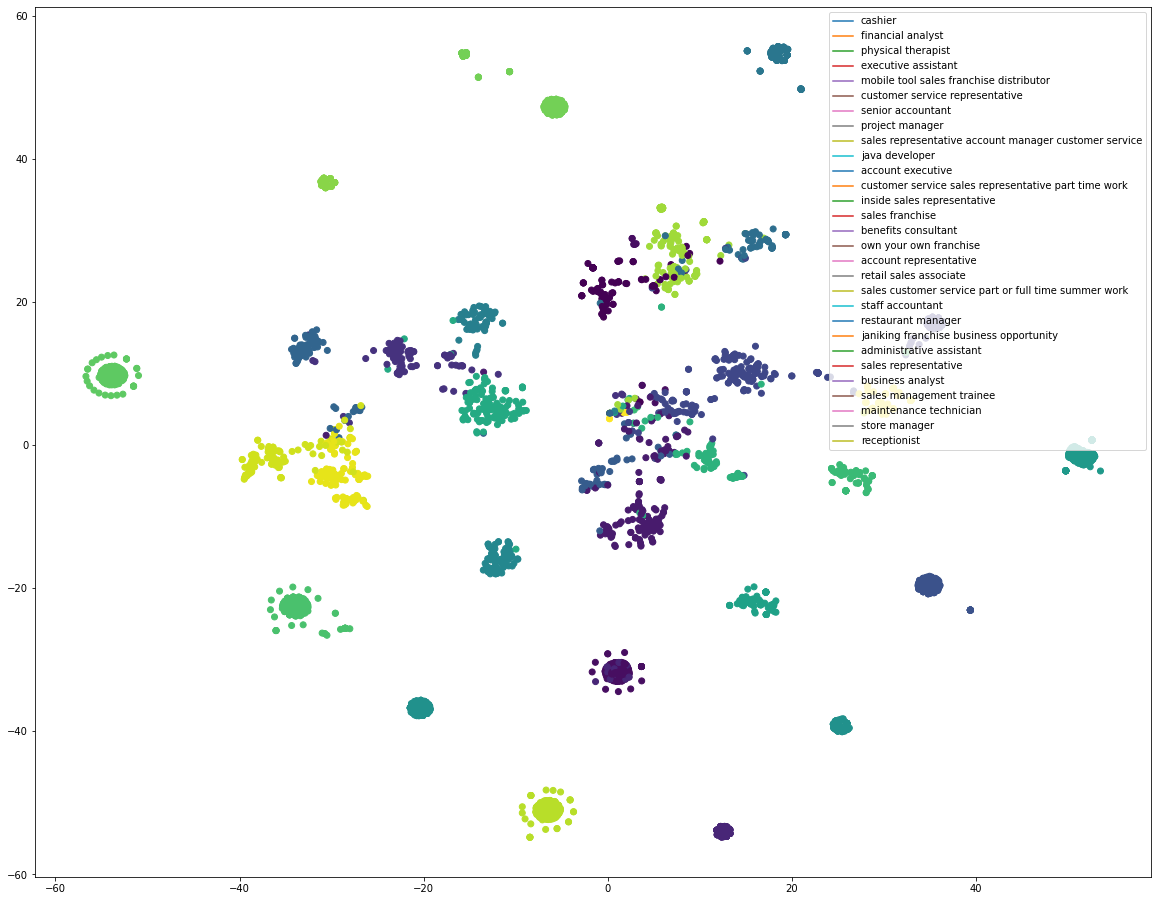

In [46]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
 
X_tsne = TSNE(learning_rate=100).fit_transform( x_list )

fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111)

ind = 0

label_list = []
for tem in X_tsne:
    if c_list[ind] not in label_list:
        ax.plot( tem[0], tem[1],label = category_dict[c_list[ind]]  )
        label_list.append( c_list[ind] )
        
    ind +=1

plt.scatter( X_tsne[:, 0], X_tsne[:, 1], c=c_list )
plt.legend()

# find the best Match 【FAISS】

In [47]:
def get_Vector_Presentation( XX ):
    layer_output = model.get_layer('concatenate').output
    intermediate_model = tf.keras.models.Model(inputs=model.input,outputs=layer_output)
    intermediate_prediction = intermediate_model.predict( XX )
    # intermediate_prediction = intermediate_model.predict( Resume_XX[0:1] )
    return intermediate_prediction

# transform CV to Vector

In [48]:
Resume_DF = pd.read_excel( 'Resumes.xlsx' ,usecols = ['title','description'])

Resume_DF['title'] = Resume_DF['title'].apply( clean_text )
Resume_DF['description'] = Resume_DF['description'].apply( clean_text )

Resume_DF['text_clean'] = Resume_DF['description'].apply( string_process )
Resume_DF['len'] = Resume_DF['text_clean'].apply(len)
Resume_DF = Resume_DF[Resume_DF['len'] < 500]

Resume_XX = np.array( PreProcessInputData( Resume_DF['text_clean'] ) )
intermediate_prediction = get_Vector_Presentation(Resume_XX)

Resume_Vector_List = []
for i in range(0,len(intermediate_prediction)):
    Resume_Vector_List.append( intermediate_prediction[i][0][0] )
    
print( Resume_XX.shape )

(65, 500)


# transform JD to Vector

In [49]:
intermediate_prediction = get_Vector_Presentation( XX )

JD_Vector_List = []
for i in range(0,len(intermediate_prediction)):
    JD_Vector_List.append( intermediate_prediction[i][0][0] )
    
np.array( JD_Vector_List ).shape

(67588, 450)

# use FAISS building Index

In [50]:
import numpy as np
import faiss                   # make faiss available

# 构造数据
import time
d = 450                           # dimension
nb = len(JD_Vector_List)                      # database size
nq = len(Resume_Vector_List)                       # nb of queries
np.random.seed(1234)             # make reproducible

xb = np.array( JD_Vector_List ).astype('float32')
xq = np.array( Resume_Vector_List ).astype('float32')

In [51]:
# 为向量集构建IndexFlatL2索引，它是最简单的索引类型，只执行强力L2距离搜索
%time index = faiss.IndexFlatL2(d)   # build the index
print(index.is_trained)
index.add(xb)                  # add vectors to the index
print(index.ntotal)

CPU times: user 83 µs, sys: 4 µs, total: 87 µs
Wall time: 396 µs
True
67588


# get a random CV

In [91]:
import random
ranIndex = random.randint( 0,len( Resume_Vector_List ) )
print( ranIndex )

k = 5
%time D, I = index.search(xq[ranIndex:ranIndex+1], k)     # actual search
print(I[0][:5])                   # neighbors of the 5 first queries

print( '-'* 120 )
print( Resume_DF['title'].iloc[ranIndex] )
print()
print( Resume_DF['description'].iloc[ranIndex] )

55
CPU times: user 17.5 ms, sys: 34 µs, total: 17.5 ms
Wall time: 15.9 ms
[50128 16689 60673 30708 51942]
------------------------------------------------------------------------------------------------------------------------
java developer

java developerjunior process associate ustglobalrockville mdjava developerpyramid systems inc washington dc2017 11 develop web applications in java html css icefaces using eclipse write scripts in sql to update databases work to improve website accessibilityjunior process associateustglobal2016 11 2017 11 refactored java programs using spring sts developed web applications in javascript angularjs nodejs html css on webstorm ide utilized cucumber for java testing utilized protractor and jasmine for javascript angularjs testing used apache subversion and git for version control experimented with mobile development using swift via xcode and java via android studioacademic internustglobal2016 6 2016 11 improved communication and soft skills programmed

# return simmilar JD  top-k

In [92]:
for ind in I[0][:5]:
    print(ind)
    print('-' * 120)
    print( data['Query'].iloc[ind] )
    print( data['Description'].iloc[ind] )

50128
------------------------------------------------------------------------------------------------------------------------
java developer
this position will support contracts with both commercial and department of defenseclients candidates must be wellversed in the java programming language along withone or more corresponding technologies such as java persistence api java eeapplication servers soap and rest services xsd xml web services stacks anduser interface technologies such as html css javascript java server faces extjs and or jquery candidates will specify design implement and test javabasedgraphical user interfaces web mobile applications and backend application dataservices candidate will also apply agile development methodologies this positionrequires the candidate to have superior writing and communication skills be detailoriented and have the ability to work both individually and as part of a team educationbachelors or masters degree in computer science computer engineer